In [1]:
import pandas as pd
import numpy as np
# import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# data source: https://www.nhtsa.gov/research-data/fatality-analysis-reporting-system-fars
# read data from Data files and put them into a list of dataframes
def readAccidentData():
    FileList = [ "FARS1975","FARS1976","FARS1977","FARS1978","FARS1979","FARS1980","FARS1981","FARS1982"
            ,"FARS1983","FARS1984","FARS1985","FARS1986","FARS1987","FARS1988","FARS1989","FARS1990"
            ,"FARS1991","FARS1992","FARS1993","FARS1994","FARS1995","FARS1996","FARS1997","FARS1998"
            ,"FARS1999","FARS2000","FARS2001","FARS2002","FARS2003","FARS2004","FARS2005","FARS2006"
            ,"FARS2007","FARS2008","FARS2009","FARS2010","FARS2011","FARS2012","FARS2013","FARS2014"
            ,"FARS2015"
               ]
    dfList = []
    print ("Reading accident data for each year from 1975 to 2015.")
    for i in FileList:
        tmpfilepath = "../Data/" + i + "/accident.csv"
        # print ("Reading ", tmpfilepath)
        tmpdf = pd.read_csv(tmpfilepath)
        # tmpSkimmedDf = tmpdf[['STATE', 'COUNTY',"FATALS"]].copy()
        dfList.append( pd.read_csv(tmpfilepath) )
        # dfList.append(tmpSkimmedDf)
    return dfList

# get the county codes, explanation: https://en.wikipedia.org/wiki/FIPS_county_code
def addcountyCode(dfList):
    for i in range(len(dfList)):
        dfList[i]['STATE'] = dfList[i]['STATE'].apply(lambda x: int(x))
        dfList[i]['STATE'] = dfList[i]['STATE'].apply(lambda x: '{0:0>2}'.format(x))
        dfList[i]['COUNTY'] = dfList[i]['COUNTY'].apply(lambda x: int(x))
        dfList[i]["COUNTY"] = dfList[i]["COUNTY"].apply(lambda x: '{0:0>3}'.format(x))
        dfList[i]["COUNTYCODE"] = dfList[i]["STATE"].astype(str)+dfList[i]["COUNTY"].astype(str)
        #print (dfList[i]['COUNTYCODE'])
    return dfList

# remove all the unnecessary columns, keep only countycode and deaths per year
def cleanDataFrame(myDfList_AccidentDataAll):
    dfList = []
    for df in myDfList_AccidentDataAll:
        tmp = df[["COUNTYCODE","FATALS"]].copy()
        tmpGrouped = tmp.groupby(['COUNTYCODE'], as_index=False).sum()
        dfList.append(tmpGrouped)
    return dfList
    

myDfList_AccidentDataAll = readAccidentData()
myDfList_AccidentDataAll = addcountyCode(myDfList_AccidentDataAll)
myDfList_AccidentData = cleanDataFrame(myDfList_AccidentDataAll)
del myDfList_AccidentDataAll

Reading accident data for each year from 1975 to 2015.


In [4]:
def combineAccidentDatawith5YearIntervals(myDfList_AccidentData):
    myDfList_AccidentData_5YearIntervals = []
    for i in range(8):
        tmp1 = myDfList_AccidentData[i+1].set_index("COUNTYCODE")
        tmp2 = myDfList_AccidentData[i+2].set_index("COUNTYCODE")
        tmp = tmp1.add(tmp2, fill_value=0)
        tmp3 = myDfList_AccidentData[i+3].set_index("COUNTYCODE")
        tmp = tmp.add(tmp3, fill_value=0)
        tmp4 = myDfList_AccidentData[i+4].set_index("COUNTYCODE")
        tmp = tmp.add(tmp4, fill_value=0)
        tmp5 = myDfList_AccidentData[i+5].set_index("COUNTYCODE")
        tmp = tmp.add(tmp5, fill_value=0)
        tmp.reset_index(inplace=True)
        tmp ["FATALS"] = tmp ["FATALS"]/5
        myDfList_AccidentData_5YearIntervals.append(tmp)
    return myDfList_AccidentData_5YearIntervals

myDfList_AccidentData_5YearIntervals = combineAccidentDatawith5YearIntervals(myDfList_AccidentData)
#myDfList_AccidentData_5YearIntervals[0]

In [5]:
# read population data from 1969 to 2015 at county level
# data source: https://seer.cancer.gov/popdata/download.html#19
def readPopData():
    filename = "../Data/us.1969_2015.19ages.txt"
    print ("Reading ",filename, ": yearly county level population data from 1969 to 2015")
    f = open(filename,"r")
    L = f.read()
    L = L.split()
    
    # extract only year, county, and population information
    year = []
    county = []
    population = []
    for x in L:
        year.append(int(x[:4]))
        county.append( str(x[6:11]) )
        population.append(int(x[18:]))
    myDf = pd.DataFrame({"YEAR" : year, "COUNTYCODE":county,"POPULATION":population})
    return myDf

def cleanPopData(df_raw):
    tmp = df_raw.groupby(['COUNTYCODE','YEAR'], as_index=False).sum()
    return tmp

def createPopList(myDf_PopulationData):
    yearList = list(range(1975,2016))
    dfList = []
    for y in yearList:
        tmp = myDf_PopulationData[myDf_PopulationData["YEAR"] == y]
        dfList.append( tmp )
    return dfList  
    
    
myDf_RawPopulationData = readPopData()
myDf_PopulationData = cleanPopData(myDf_RawPopulationData)
myDfList_PopData = createPopList(myDf_PopulationData)

Reading  ../Data/us.1969_2015.19ages.txt : yearly county level population data from 1969 to 2015


In [8]:
def combinePopDatawith5YearIntervals(myDfList_PopData):
    myDfList_PopData_5YearIntervals = []
    for i in range(8):
        tmp1 = myDfList_PopData[i+1].set_index("COUNTYCODE")
        tmp1 = tmp1.drop('YEAR', 1)
        tmp2 = myDfList_PopData[i+2].set_index("COUNTYCODE")
        tmp2 = tmp2.drop('YEAR', 1)
        tmp = tmp1.add(tmp2, fill_value=0)
        tmp3 = myDfList_PopData[i+3].set_index("COUNTYCODE")
        tmp3 = tmp3.drop('YEAR', 1)
        tmp = tmp.add(tmp3, fill_value=0)
        tmp4 = myDfList_PopData[i+3].set_index("COUNTYCODE")
        tmp4 = tmp4.drop('YEAR', 1)
        tmp = tmp.add(tmp4, fill_value=0)
        tmp5 = myDfList_PopData[i+3].set_index("COUNTYCODE")
        tmp5 = tmp5.drop('YEAR', 1)
        tmp = tmp.add(tmp5, fill_value=0)
        tmp.reset_index(inplace=True)
        tmp["POPULATION"] = tmp["POPULATION"]/5
        myDfList_PopData_5YearIntervals.append(tmp)
    return myDfList_PopData_5YearIntervals

myDfList_PopData_5YearIntervals = combinePopDatawith5YearIntervals(myDfList_PopData)
#myDfList_PopData_5YearIntervals[0]

In [9]:
def readFPISCodes():
    df = pd.read_excel("../Data/US_FIPS_Codes.xls", dtype=object)
    df["COUNTYCODE"] = df["FIPS State"]+df["FIPS County"]
    df["COUNTY"] = df["State"]+","+df["County Name"]
    tmp = df[['COUNTYCODE', 'COUNTY']].copy()
    return tmp

dfFPIS = readFPISCodes()
myDict_FPIS = dfFPIS.set_index('COUNTYCODE').to_dict()
myCountyCodeList = list(dfFPIS["COUNTYCODE"])

In [10]:
def shrinkFitRange(yearList,deathList):
   
    i = 0
    y = deathList
    x = yearList
    while (deathList[i]==0) and i < (len(deathList)-1):
        y = deathList[i+1:]
        x = yearList[i+1:]
        i = i+1

    i = len(y)-1
    new_x = x
    new_y = y
    while (y[i]==0) and (i > 0):
        new_y = y[:i-1]
        new_x = x[:i-1]
        i = i-1
    
    return new_x,new_y

In [12]:

def plotDeathRatePerCountyBenchMark(myDfList_AccidentData_5YearIntervals,myDict_FPIS,countyCode):
    deathList = []
    yearList = [1976,1981,1986,1991,1996,2001,2006]
    
    for i in range(len(myDfList_AccidentData_5YearIntervals)-1):
        tmp = myDfList_AccidentData_5YearIntervals[i]
        tmp = tmp[ tmp["COUNTYCODE"] == countyCode ]
        deathList.append( tmp["FATALS"].sum())
 

    # deathList = smoothDeathRate(deathList)
    shrinkedYearList,shrinkedDeathList = shrinkFitRange(yearList,deathList)
    if(len(shrinkedYearList)<2): return 0
    p = np.polyfit(shrinkedYearList,shrinkedDeathList,2)
    f = np.poly1d(p)
    
    x_new = np.linspace(shrinkedYearList[0], shrinkedYearList[-1], 100)
    y_new = f(x_new)
    
    # textstr = 'y=%.2f*x + %.2f'%(p[0], p[1])
    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    ax.plot(yearList,deathList,"ro", x_new, y_new)
    # these are matplotlib.patch.Patch properties
    # props = dict(boxstyle='round', facecolor='green', alpha=0.5)
    # place a text box in upper left in axes coords
    # ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.xlabel('5 Year Intervals')
    plt.ylabel('Average Total Deaths/ 5 Years')
    plt.title(myDict_FPIS["COUNTY"][countyCode])
    # plt.show()
    figName = '../Fig/LinearFitTotalDeaths_'+countyCode+'_5Years.pdf'
    fig.savefig(figName)
    plt.close(fig) # close the figure
    return f(2011)
    # num = plotDeathRatePerCountyBenchMark(myDfList_AccidentData_5YearIntervals,myDict_FPIS,"05005")

crashRatePrediction_2011_2015 = {}
for countyCode in myCountyCodeList:
    num = plotDeathRatePerCountyBenchMark(myDfList_AccidentData_5YearIntervals,myDict_FPIS,countyCode)
    if num<0:
        crashRatePrediction_2011_2015[countyCode] = 0
    else:
        crashRatePrediction_2011_2015[countyCode] = num

/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app


In [11]:
def plotPopIncreasePerCountyBenchMark(myDfList_PopData_5YearIntervals,myDict_FPIS,countyCode):
    yearList = [1976,1981,1986,1991,1996,2001,2006]
    populationList = np.empty([len(yearList)])
    
    for i in range(len(myDfList_PopData_5YearIntervals)-1):
        tmp = myDfList_PopData_5YearIntervals[i]
        tmp = tmp[ tmp["COUNTYCODE"] == countyCode ]
        populationList[i] = tmp["POPULATION"].sum()
    
    shrinkedYearList,shrinkedPopList = shrinkFitRange(yearList,populationList)
    p = np.polyfit(shrinkedYearList,shrinkedPopList,4)
    f = np.poly1d(p)
    
    # calculate new x's and y's
    x_new = np.linspace(shrinkedYearList[0], shrinkedYearList[-1], 100)
    y_new = f(x_new)
    
    
    fig, ax = plt.subplots( nrows=1, ncols=1 ) # create figure & 1 axis
    ax.plot(yearList,populationList,"ro", x_new, y_new)
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    # ax.text(0.40, 0.15, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.xlabel('5 Year Intervals')
    plt.ylabel('Average Population/ 5 Years')
    plt.title(myDict_FPIS["COUNTY"][countyCode])
    # plt.show()
    figName = '../Fig/LinearPopulationIncreaseFit_'+countyCode+'_5Years.pdf'
    fig.savefig(figName)
    plt.close(fig) # close the figure
    
    
    return f(2011)

populationPrediction_2011_2015 = {}
for countyCode in myCountyCodeList:
    num = plotPopIncreasePerCountyBenchMark(myDfList_PopData_5YearIntervals,myDict_FPIS,countyCode)
    if num<0:
        populationPrediction_2011_2015[countyCode] = 0
    else:
        populationPrediction_2011_2015[countyCode] = num


/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWar

/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/sdurgut/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWar

In [13]:
#populationPrediction_2011_2015
#crashRatePrediction_2011_2015



df_Crash2011_2015 = pd.DataFrame()
df_Crash2011_2015["CountyCode"] = crashRatePrediction_2011_2015.keys()
df_Crash2011_2015["Fatals"] = crashRatePrediction_2011_2015.values()

df_Population2011_2015 = pd.DataFrame()
df_Population2011_2015["CountyCode"] = populationPrediction_2011_2015.keys()
df_Population2011_2015["Population"] = populationPrediction_2011_2015.values()

df_2011_2015Prediction =  pd.merge(df_Crash2011_2015, df_Population2011_2015, on='CountyCode', how='outer')
df_2011_2015Prediction["FatalityRatePrediction"] = 10000*df_2011_2015Prediction["Fatals"]/df_2011_2015Prediction["Population"]
df_2011_2015Prediction= df_2011_2015Prediction.replace([np.inf, -np.inf], np.nan).dropna(subset=["FatalityRatePrediction"], how="all")

df_2011_2015Prediction.to_csv("../CreateSVG/FatalityPredictionData_2011_2015.csv",header=False, index = False)



df_2011_2015ActualData = pd.merge(myDfList_AccidentData_5YearIntervals[-1], myDfList_PopData_5YearIntervals[-1], on='COUNTYCODE', how='inner')
df_2011_2015ActualData["FatalityRateActual"] = 10000*df_2011_2015ActualData["FATALS"]/df_2011_2015ActualData["POPULATION"]
df_2011_2015ActualData = df_2011_2015ActualData.rename(columns={'COUNTYCODE': 'CountyCode', 'FATALS': 'Fatals', 'POPULATION': 'Population',"YEAR":"Year"})
df_2011_2015ActualData.to_csv("../CreateSVG/FatalityActualData_2011_2015.csv",header=False, index = False)

# df_2011_2015Prediction



In [33]:
df_BenchMark = pd.merge(df_2011_2015Prediction, df_2011_2015ActualData, on='CountyCode', how='inner')
df_BenchMark["Error"] = 100*abs(df_BenchMark["FatalityRateActual"]-df_BenchMark["FatalityRatePrediction"])/df_BenchMark["FatalityRateActual"]
df_BenchMark["Error"].mean()
df_Error = df_BenchMark[df_BenchMark["Population_y"] > 50000]
df_Error["Error"].mean()


10.980059623624442

In [34]:
# tmp = pd.DataFrame()
# tmp["Actual"] = df_BenchMark["FatalityRateActual"]
# tmp["Prediction"] = df_BenchMark["FatalityRatePrediction"]
df_Error.corr()



,Fatals_x,Population_x,FatalityRatePrediction,Fatals_y,Population_y,FatalityRateActual,Error
Fatals_x,1.000000,0.898762,-0.041435,0.997821,0.929112,-0.055627,-0.139444
Population_x,0.898762,1.000000,-0.252505,0.900242,0.988476,-0.258768,-0.001325
FatalityRatePrediction,-0.041435,-0.252505,1.000000,-0.058107,-0.243397,0.963316,-0.272943
Fatals_y,0.997821,0.900242,-0.058107,1.000000,0.930490,-0.061018,-0.112061
Population_y,0.929112,0.988476,-0.243397,0.930490,1.000000,-0.252676,-0.047275
FatalityRateActual,-0.055627,-0.258768,0.963316,-0.061018,-0.252676,1.000000,-0.162687
Error,-0.139444,-0.001325,-0.272943,-0.112061,-0.047275,-0.162687,1.000000


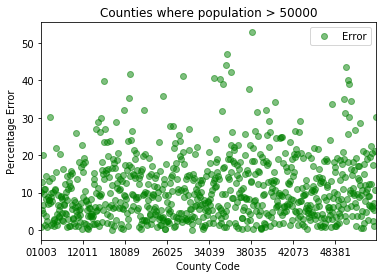

In [51]:
df_Error.plot(x="CountyCode",y="Error",style='o',alpha=0.5,c='g')
plt.xlabel('County Code')
plt.ylabel('Percentage Error')
plt.title("Counties where population > 50000")
plt.savefig("../Fig/PercentageError_5Years.pdf")
plt.show()


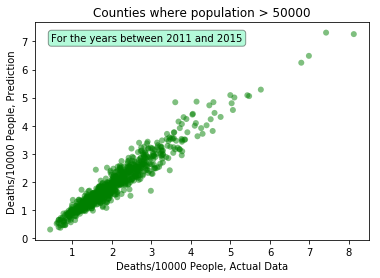

In [43]:
fig = plt.figure()
ax = plt.gca()

ax.scatter(df_Error["FatalityRateActual"],df_Error["FatalityRatePrediction"], c='green', alpha=0.5, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
textstr = 'For the years between 2011 and 2015'
props = dict(boxstyle='round', facecolor='#42f4a1', alpha=0.4)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)

plt.xlabel("Deaths/10000 People, Actual Data")
plt.ylabel("Deaths/10000 People, Prediction")
plt.title("Counties where population > 50000")
plt.show()
fig.savefig("../Fig/Scatter_ActualvsPrediction_5Years.pdf")
plt.close(fig) # close the figure

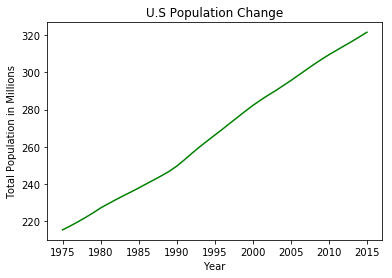

In [63]:
yearList = np.arange(1975,2016)
populationList = []
for i in range(len(myDfList_PopData)):
    populationList.append( myDfList_PopData[i]["POPULATION"].sum()/1000000 )

fig = plt.figure()
ax = plt.gca()

ax.plot(yearList,populationList, c='green')
#textstr = 'Total population is U.S.'
#props = dict(boxstyle='round', facecolor='#42f4a1', alpha=0.4)
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)

plt.xlabel("Year")
plt.ylabel("Total Population in Millions")
plt.title("U.S Population Change")
plt.show()
fig.savefig("../Fig/Total_US_Population.pdf")
plt.close(fig) # close the figure